# Training a neural network with McSnow accretion output

This script applies a DNN to the regression problem compare with Seifert and Beheng (2001)

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


### Load Tensorflow and other useful modules

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


### Load data from netcdf

In [2]:
import numpy as np
import xarray as xr

In [3]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'
fname1=mdir+edir+'autocon_train_small.nc'
fname2=mdir+edir+'autocon_test_small.nc'

ds1 = xr.open_dataset(fname1)
ds2 = xr.open_dataset(fname2)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:     (i: 5, ii: 5, j: 5, jj: 5, k: 3, kk: 3, n: 2, nn: 2, nt: 4000)
Coordinates:
  * n           (n) int32 0 1
  * i           (i) int32 400 600 800 1000 2000
  * j           (j) int32 11 12 13 14 15
  * k           (k) int32 0 1 2
Dimensions without coordinates: ii, jj, kk, nn, nt
Data variables:
    time        (n, i, j, k, nt) float32 ...
    tau         (n, i, j, k, nt) float32 ...
    Lc          (n, i, j, k, nt) float32 ...
    Nc          (n, i, j, k, nt) float32 ...
    Zc          (n, i, j, k, nt) float32 ...
    Lr          (n, i, j, k, nt) float32 ...
    Nr          (n, i, j, k, nt) float32 ...
    Zr          (n, i, j, k, nt) float32 ...
    nu          (n, i, j, k, nt) float32 ...
    mue         (n, i, j, k, nt) float64 ...
    nue         (n, i, j, k, nt) float64 ...
    auto_num    (n, i, j, k, nt) float32 ...
    auto_mass   (n, i, j, k, nt) float32 ...
    accr_num    (n, i, j, k, nt) float32 ...
    accr_mass   (n, i, j, k, nt) floa

# Prepare data for training

In [4]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    tau  = xr.open_dataset(fname).tau.values
    acc  = xr.open_dataset(fname).accr_norm.values
    Lc   = xr.open_dataset(fname).Lc.values
    Lr   = xr.open_dataset(fname).Lr.values
    Nc   = xr.open_dataset(fname).Nc.values
    Nr   = xr.open_dataset(fname).Nr.values
    nu   = xr.open_dataset(fname).nu.values
    # transform everything except nu in log space
    L_min = 1e-15
    N_min = 1e-15
    tau_min  = 1e-15
    acc_min = 7e-10
    Xc = np.log(Lc/Nc, where=Nc>N_min)
    Xr = np.log(Lr/Nr, where=Nr>N_min)  # do Xr first!
    Nc = np.log(Nc, where=Nc>N_min)
    Lc = np.log(Lc, where=Lc>L_min)
    Nr = np.log(Nr, where=Nr>N_min)
    Lr = np.log(Lr, where=Lr>L_min)
    tau = np.log(tau, where=tau>tau_min, out=np.nan*tau)    
    acc = np.log(acc, where=acc>acc_min, out=np.nan*acc)
    # put everything in a pandas dataframe    
    dataset = pd.DataFrame(np.array( [ acc.ravel(), Xc.ravel(), Xr.ravel(), nu.ravel(), tau.ravel() ]))
    dataset = dataset.T
    dataset.columns = ['acc','Xc','Xr','nu','tau'] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [5]:
dataset_train = read_and_prepare_data(fname1)
dataset_test  = read_and_prepare_data(fname2)

/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.

### Inspect the data

In [6]:
dataset_train.describe()

acc            Xc            Xr            nu           tau
count  32332.000000  32332.000000  32332.000000  32332.000000  32332.000000
mean      -0.353739    -25.702991    -17.927168      1.072158     -3.412088
std        0.455765      0.566637      3.502115      0.808373      5.341979
min      -10.515717    -28.129522    -22.068405      0.000000    -29.799511
25%       -0.503165    -25.897650    -21.303797      0.000000     -4.893186
50%       -0.265676    -25.622589    -18.802380      1.000000     -0.664908
75%       -0.086623    -25.337555    -14.657531      2.000000     -0.017072
max        1.107027    -24.881920    -10.716539      2.000000     -0.001001

In [7]:
dataset_test.describe()

acc            Xc            Xr            nu           tau
count  12209.000000  12209.000000  12209.000000  12209.000000  12209.000000
mean      -0.359184    -25.704052    -17.939659      1.074208     -3.452977
std        0.453361      0.564573      3.505779      0.807892      5.406150
min      -10.733914    -28.135550    -22.067808      0.000000    -30.277874
25%       -0.506137    -25.898771    -21.322699      0.000000     -4.935174
50%       -0.269904    -25.623974    -18.836670      1.000000     -0.678276
75%       -0.092676    -25.339451    -14.667350      2.000000     -0.017200
max        0.867125    -24.882051    -10.629810      2.000000     -0.001001

### Reduce data

In [8]:
def reduce_data(dataset):
    idx = dataset[ dataset['tau'] > np.log(0.95) ].index
    dataset.drop(idx,inplace=True)
    return dataset

In [9]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)

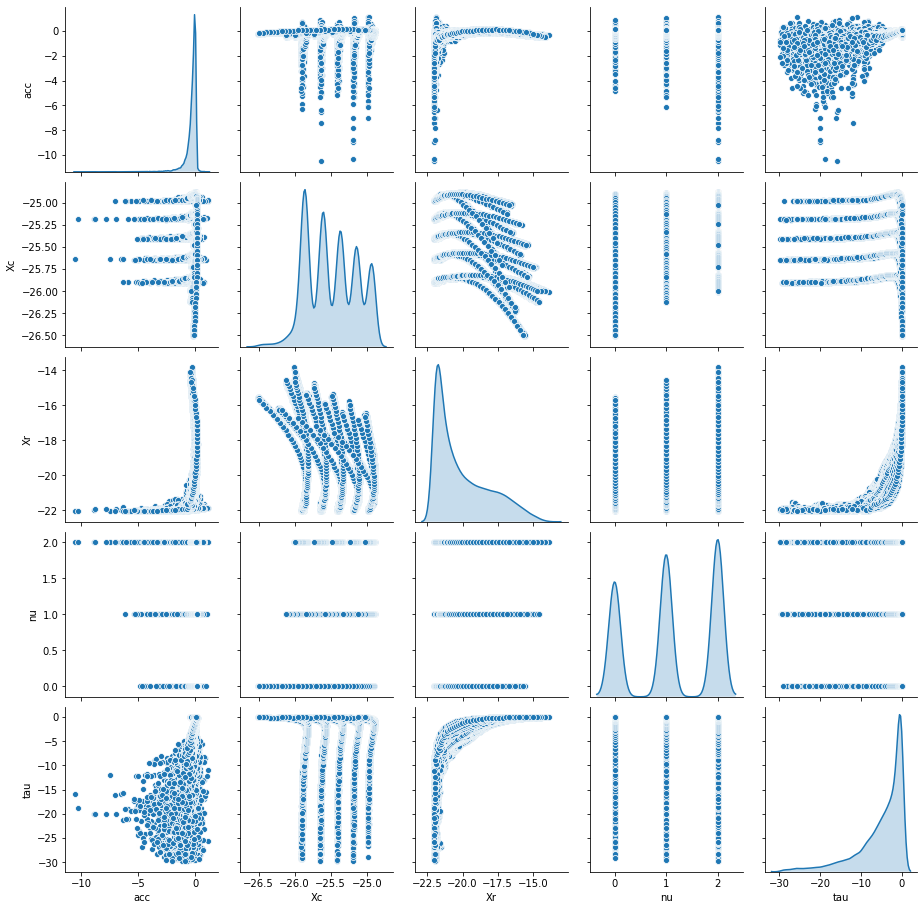

In [10]:
sns.pairplot(dataset_train[['acc','Xc','Xr','nu','tau']], diag_kind="kde")

## Separate in different dataset with selected sets of predictors

In [11]:
train_dataset0 = dataset_train.copy()
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()
train_dataset4 = dataset_train.copy()

test_dataset0 = dataset_test.copy()
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()
test_dataset4 = dataset_test.copy()

In [12]:
train_dataset0 = train_dataset0.drop(['Xc','nu','tau'], axis=1)
train_dataset1 = train_dataset1.drop(['Xr','nu','tau'], axis=1)
train_dataset2 = train_dataset2.drop(['Xc','Xr','nu'], axis=1)
train_dataset3 = train_dataset3.drop(['tau'], axis=1)
#train_dataset4 = train_dataset4.drop(['tau'], axis=1)   # keep everything

In [13]:
test_dataset0 = test_dataset0.drop(['Xc','nu','tau'], axis=1)
test_dataset1 = test_dataset1.drop(['Xr','nu','tau'], axis=1)
test_dataset2 = test_dataset2.drop(['Xc','Xr','nu'], axis=1)
test_dataset3 = test_dataset3.drop(['tau'], axis=1)
#test_dataset4 = test_dataset4.drop(['tau'], axis=1)  # keep everything

In [14]:
train_stats0 = train_dataset0.describe()
train_stats0.pop("acc")
train_stats0 = train_stats0.transpose()
train_stats0

count       mean       std        min       25%        50%        75%  \
Xr  21690.0 -20.043425  1.914052 -22.068405 -21.65541 -20.747854 -18.756494   

          max  
Xr -13.829313

In [15]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("acc")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%        75%  \
Xc  21690.0 -25.482941  0.342861 -26.510252 -25.825531 -25.564007 -25.168272   

         max  
Xc -24.88192

In [16]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("acc")
train_stats2 = train_stats2.transpose()
train_stats2

count      mean       std        min       25%       50%       75%  \
tau  21690.0 -5.080681  5.837834 -29.799511 -7.297567 -3.064323 -0.639297   

          max  
tau -0.051293

In [17]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("acc")
train_stats3 = train_stats3.transpose()
train_stats3

count       mean       std        min        25%        50%        75%  \
Xc  21690.0 -25.482941  0.342861 -26.510252 -25.825531 -25.564007 -25.168272   
Xr  21690.0 -20.043425  1.914052 -22.068405 -21.655410 -20.747854 -18.756494   
nu  21690.0   1.102305  0.803950   0.000000   0.000000   1.000000   2.000000   

          max  
Xc -24.881920  
Xr -13.829313  
nu   2.000000

In [18]:
train_stats4 = train_dataset4.describe()
train_stats4.pop("acc")
train_stats4 = train_stats4.transpose()
train_stats4

count       mean       std        min        25%        50%        75%  \
Xc   21690.0 -25.482941  0.342861 -26.510252 -25.825531 -25.564007 -25.168272   
Xr   21690.0 -20.043425  1.914052 -22.068405 -21.655410 -20.747854 -18.756494   
nu   21690.0   1.102305  0.803950   0.000000   0.000000   1.000000   2.000000   
tau  21690.0  -5.080681  5.837834 -29.799511  -7.297567  -3.064323  -0.639297   

           max  
Xc  -24.881920  
Xr  -13.829313  
nu    2.000000  
tau  -0.051293

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [19]:
train_labels0 = train_dataset0.pop('acc')
train_labels1 = train_dataset1.pop('acc')
train_labels2 = train_dataset2.pop('acc')
train_labels3 = train_dataset3.pop('acc')
train_labels4 = train_dataset4.pop('acc')

test_labels0  = test_dataset0.pop('acc')
test_labels1  = test_dataset1.pop('acc')
test_labels2  = test_dataset2.pop('acc')
test_labels3  = test_dataset3.pop('acc')
test_labels4  = test_dataset4.pop('acc')

### Normalize the data

In [20]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data0 = norm(train_dataset0,train_stats0)
normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)
normed_train_data4 = norm(train_dataset4,train_stats4)

normed_test_data0 = norm(test_dataset0,train_stats0)
normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)
normed_test_data4 = norm(test_dataset4,train_stats4)

In [21]:
normed_train_stats0 = normed_train_data0.describe()
normed_train_stats0 = normed_train_stats0.transpose()
normed_train_stats0

count     mean       std       min       25%       50%      75%  \
Xr  21690.0  0.00001  0.999999 -1.057955 -0.842185 -0.368031  0.67236   

         max  
Xr  3.246575

In [22]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count      mean       std      min       25%      50%       75%  \
Xc  21690.0 -0.000084  0.999999 -2.99629 -0.999212 -0.23644  0.917772   

         max  
Xc  1.752957

In [23]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count      mean  std       min       25%       50%       75%       max
tau  21690.0  0.000001  1.0 -4.234246 -0.379744  0.345395  0.760793  0.861516

In [24]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean       std       min       25%       50%       75%  \
Xc  21690.0 -8.426730e-05  0.999999 -2.996290 -0.999212 -0.236440  0.917772   
Xr  21690.0  9.830460e-06  0.999999 -1.057955 -0.842185 -0.368031  0.672360   
nu  21690.0  4.465474e-08  1.000057 -1.371111 -1.371111 -0.127253  1.116605   

         max  
Xc  1.752957  
Xr  3.246575  
nu  1.116605

In [25]:
normed_train_stats4 = normed_train_data4.describe()
normed_train_stats4 = normed_train_stats4.transpose()
normed_train_stats4

count          mean       std       min       25%       50%       75%  \
Xc   21690.0 -8.426730e-05  0.999999 -2.996290 -0.999212 -0.236440  0.917772   
Xr   21690.0  9.830460e-06  0.999999 -1.057955 -0.842185 -0.368031  0.672360   
nu   21690.0  4.465474e-08  1.000057 -1.371111 -1.371111 -0.127253  1.116605   
tau  21690.0  1.246117e-06  1.000000 -4.234246 -0.379744  0.345395  0.760793   

          max  
Xc   1.752957  
Xr   3.246575  
nu   1.116605  
tau  0.861516

# The model

## Build the model

In [26]:
def build_model_tanh(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='tanh'),
    layers.Dense(16, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,activation,learning_rate):
    if activation == "tanh":
        model = build_model_tanh(ncol,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [27]:

#activ = "PReLU"
#activ = "LReLU"
activ = "tanh"
#activ = "ReLU"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"

model = build_model(1,activ,1e-3)


### Inspect the model

Use the `.summary` method to print a simple description of the model

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                32        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 593
Trainable params: 593
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [29]:
example_batch  = normed_train_data0[:10]
example_result = model.predict(example_batch)
example_result

array([[0.6677003 ],
       [0.6593157 ],
       [0.66338253],
       [0.6629966 ],
       [0.66354084],
       [0.6655309 ],
       [0.659295  ],
       [0.65239084],
       [0.6710907 ],
       [0.66363466]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [30]:
# maximum number, but we use early stopping
EPOCHS = 1000

# part of training data that is used for validation during training
VALSPLIT = 0.3

# learning rate
learn = 1e-4        # original value was 1e-3

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# for collecting the histories
histories = {}

In [31]:
model0 = build_model(len(normed_train_data0.keys()),activ,learn)

early_history0 = model0.fit(normed_train_data0, train_labels0, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.2479,  mae:0.2632,  mse:0.2479,  val_loss:0.2097,  val_mae:0.2427,  val_mse:0.2097,  
....................................................................................................
Epoch: 100, loss:0.1313,  mae:0.1585,  mse:0.1313,  val_loss:0.0944,  val_mae:0.1367,  val_mse:0.0944,  
................................................................

Text(0, 0.5, 'MAE')

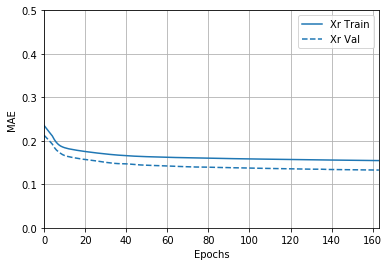

In [32]:
histories['Xr'] = early_history0

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 0.5])
plt.ylabel('MAE')

In [33]:
model1 = build_model(len(normed_train_data1.keys()),activ,learn)

early_history1 = model1.fit(normed_train_data1, train_labels1, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.3132,  mae:0.2985,  mse:0.3132,  val_loss:0.2815,  val_mae:0.3036,  val_mse:0.2815,  
.........................

Text(0, 0.5, 'MAE')

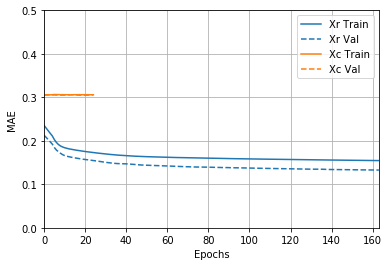

In [34]:
histories['Xc'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 0.5])
plt.ylabel('MAE')

In [35]:
model2 = build_model(len(normed_train_data2.keys()),activ,learn)

early_history2 = model2.fit(normed_train_data2, train_labels2, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1915,  mae:0.2109,  mse:0.1915,  val_loss:0.1406,  val_mae:0.1625,  val_mse:0.1406,  
.....................

Text(0, 0.5, 'MAE')

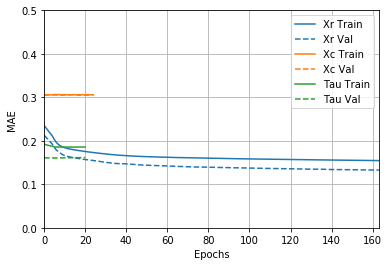

In [36]:
histories['tau'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 0.5])
plt.ylabel('MAE')

In [37]:
model3 = build_model(len(normed_train_data3.keys()),activ,learn)

early_history3 = model3.fit(normed_train_data3, train_labels3, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.2584,  mae:0.2644,  mse:0.2584,  val_loss:0.2039,  val_mae:0.2326,  val_mse:0.2039,  
....................................................................................................
Epoch: 100, loss:0.1405,  mae:0.1509,  mse:0.1405,  val_loss:0.1067,  val_mae:0.1294,  val_mse:0.1067,  
....................................................................................................
Epoch: 200, loss:0.1238,  mae:0.1402,  mse:0.1238,  val_loss:0.0853,  val_mae:0.1172,  val_mse:0.0853,  
...................

Text(0, 0.5, 'MAE')

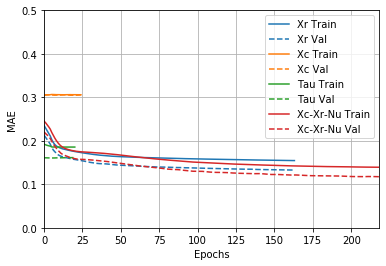

In [38]:
histories['Xc-Xr-nu'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 0.5])
plt.ylabel('MAE')

In [39]:
model4 = build_model(len(normed_train_data4.keys()),activ,learn)

early_history4 = model4.fit(normed_train_data4, train_labels4, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.2716,  mae:0.2804,  mse:0.2716,  val_loss:0.1429,  val_mae:0.1590,  val_mse:0.1429,  
..................................

Text(0, 0.5, 'MAE of AU')

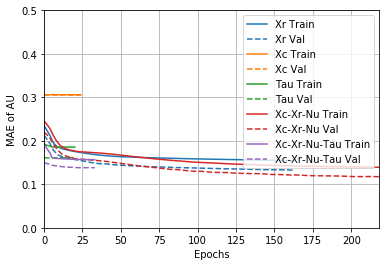

In [40]:
histories['Xc-Xr-nu-tau'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0, 0.5])
plt.ylabel('MAE of AU')

Text(0, 0.5, 'MSE of AU')

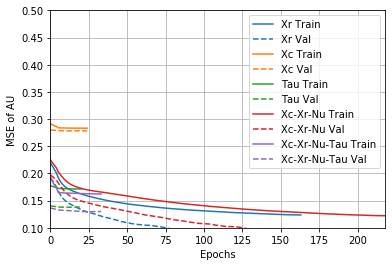

In [41]:
plotter.plot(histories, metric = "mse")
plt.ylim([0.1, 0.5])
plt.ylabel('MSE of AU')

In [42]:
loss0, mae0, mse0 = model0.evaluate(normed_test_data0, test_labels0, verbose=2)

print("Testing set for model 0, Mean Abs Error: {:10.5f}".format(mae0))

8205/8205 - 0s - loss: 0.1042 - mae: 0.1377 - mse: 0.1042
Testing set for model 0, Mean Abs Error:    0.13774


In [43]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, test_labels1, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

8205/8205 - 0s - loss: 0.2770 - mae: 0.3037 - mse: 0.2770
Testing set for model 1, Mean Abs Error:    0.30368


In [44]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data2, test_labels2, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:10.5f}".format(mae2))

8205/8205 - 0s - loss: 0.1527 - mae: 0.1710 - mse: 0.1527
Testing set for model 2, Mean Abs Error:    0.17102


In [45]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data3, test_labels3, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:10.5f}".format(mae3))

8205/8205 - 0s - loss: 0.1030 - mae: 0.1225 - mse: 0.1030
Testing set for model 3, Mean Abs Error:    0.12251


In [46]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data4, test_labels4, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:10.5f}".format(mae4))

8205/8205 - 0s - loss: 0.1433 - mae: 0.1407 - mse: 0.1433
Testing set for model 4, Mean Abs Error:    0.14074


# Make predictions

Finally, predict the fall velocity values using data in the testing set:

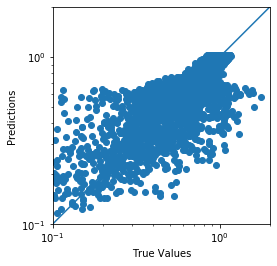

In [47]:
test_acc0 = np.exp(test_labels0)
test_acc1 = np.exp(test_labels1)
test_acc2 = np.exp(test_labels2)
test_acc3 = np.exp(test_labels3)
test_acc4 = np.exp(test_labels4)

test_predict0 = np.exp(model0.predict(normed_test_data0).flatten())
test_predict1 = np.exp(model1.predict(normed_test_data1).flatten())


test_predict2 = np.exp(model2.predict(normed_test_data2).flatten())

amin, amax = 0.1, 2

a = plt.axes(aspect='equal')
plt.scatter(test_acc0, test_predict0)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

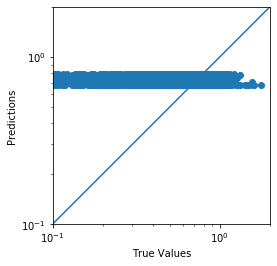

In [48]:
a = plt.axes(aspect='equal')
plt.scatter(test_acc1, test_predict1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

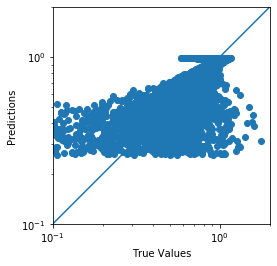

In [49]:
a = plt.axes(aspect='equal')
plt.scatter(test_acc1, test_predict2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

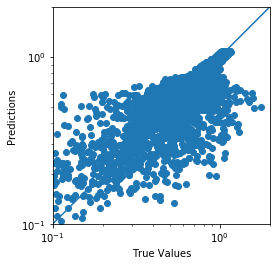

In [50]:
test_predict3 = np.exp(model3.predict(normed_test_data3).flatten())

a = plt.axes(aspect='equal')
plt.scatter(test_acc3, test_predict3)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

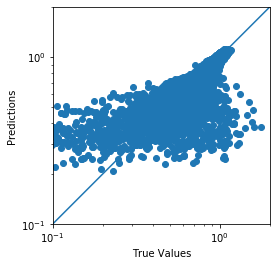

In [51]:
test_predict4 = np.exp(model4.predict(normed_test_data4).flatten())

a = plt.axes(aspect='equal')
plt.scatter(test_acc4, test_predict4)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Compare with SB2001 and KK2000

In [52]:
test_dataset4.describe()

Xc           Xr           nu          tau
count  8205.000000  8205.000000  8205.000000  8205.000000
mean    -25.484619   -20.054159     1.105545    -5.132433
std       0.343341     1.911117     0.803823     5.906701
min     -26.507778   -22.067808     0.000000   -30.277874
25%     -25.826534   -21.656441     0.000000    -7.380908
50%     -25.564945   -20.759312     1.000000    -3.093131
75%     -25.168873   -18.778122     2.000000    -0.645219
max     -24.882051   -14.060974     2.000000    -0.051351

In [53]:
tau2 = np.exp(test_dataset4.tau)
tau2

5         1.728355e-12
6         5.576744e-11
7         5.976358e-11
8         8.052384e-11
9         1.437103e-10
              ...     
236055    9.040338e-01
236056    9.182516e-01
236057    9.303204e-01
236058    9.405510e-01
236059    9.492924e-01
Name: tau, Length: 8205, dtype: float32

## SB2001 accretion rate

In [54]:
kcr = 5.78      # Long kernel in m3 kg-1 s-1 

phi = (tau2 / (tau2 + 5e-4))**4

accSB = phi
#accSB = kcr * qc * qr * phi

phi

5         1.427749e-34
6         1.547543e-28
7         2.041109e-28
8         6.726941e-28
9         6.824510e-27
              ...     
236055    9.977908e-01
236056    9.978248e-01
236057    9.978531e-01
236058    9.978762e-01
236059    9.978960e-01
Name: tau, Length: 8205, dtype: float32

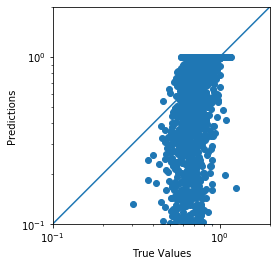

In [55]:
test_predict_sb = accSB

a = plt.axes(aspect='equal')
plt.scatter(test_acc4, test_predict_sb)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## Final statistics 

In [56]:
acc0 = test_predict0
acc1 = test_predict1
acc2 = test_predict2
acc3 = test_predict3
acc4 = test_predict4

accTruth = test_acc4

In [57]:
np.max(accTruth)

2.380059242248535

In [58]:
def mean_abs_error(au, auTrue):  
    return np.mean(np.abs(au - auTrue))

def mean_sqr_error(au, auTrue):    
    return np.sqrt(np.mean((au - auTrue)**2))                   

In [59]:
mae0 = mean_abs_error(acc0,test_acc0)
mae1 = mean_abs_error(acc1,test_acc1)
mae2 = mean_abs_error(acc2,test_acc2)
mae3 = mean_abs_error(acc3,test_acc3)
mae4 = mean_abs_error(acc4,test_acc4)
maeSB = mean_abs_error(accSB,accTruth)
#maeKK  = mean_abs_error(accKK,accTruth)
#maePwr = mean_abs_error(accPwr,accTruth)

mse0 = mean_sqr_error(acc0,test_acc0)
mse1 = mean_sqr_error(acc1,test_acc1)
mse2 = mean_sqr_error(acc2,test_acc2)
mse3 = mean_sqr_error(acc3,test_acc3)
mse4 = mean_sqr_error(acc4,test_acc4)
mseSB = mean_sqr_error(accSB,accTruth)
#mseSB2 = mean_sqr_error(accSB2,accTruth)
#mseKK  = mean_sqr_error(accKK,accTruth)
#msePwr = mean_sqr_error(accPwr,accTruth)

mae = [ mae0, mae1, mae2, mae3, mae4, maeSB ] #, maeSB2, maeKK, maePwr ]
mse = [ mse0, mse1, mse2, mse3, mse4, mseSB ] #, mseSB2, mseKK, msePwr ]

In [60]:
mae

[0.0765000656247139,
 0.1929243803024292,
 0.09305984526872635,
 0.0612638033926487,
 0.06781478971242905,
 0.2120002806186676]

In [61]:
labels = list(histories.keys())
labels.append('SB2001')
labels

['Xr', 'Xc', 'tau', 'Xc-Xr-nu', 'Xc-Xr-nu-tau', 'SB2001']

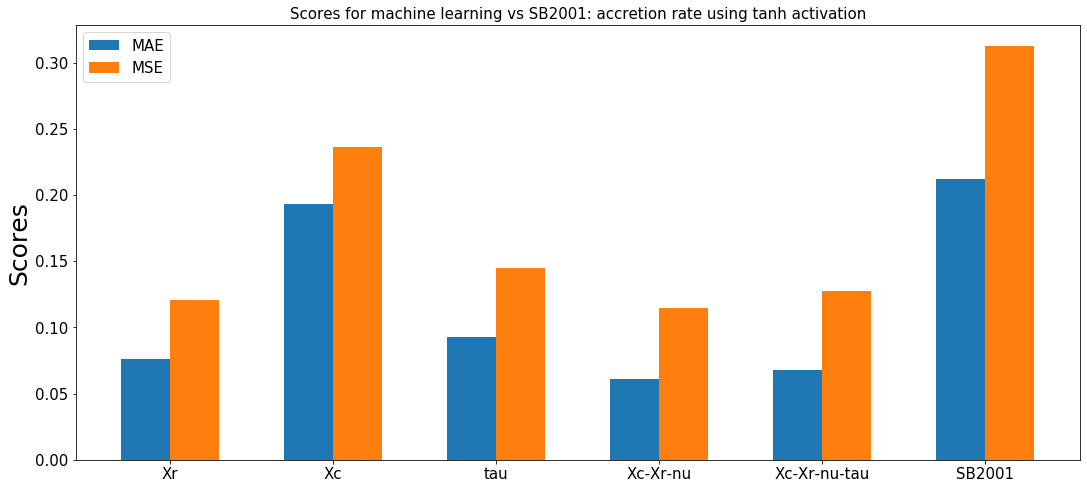

In [62]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size
#labels = [ 'Lc-Lr', 'Lc-Lr-Nc', 'Lc-Lr-Nr', 'Lc-Lr-Nc-Nr', 'Lc-Lr-Nc-Nr-nu', 'SB2001' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mae, width, label='MAE')
rects2 = ax.bar(x + width/2, mse, width, label='MSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores for machine learning vs SB2001: accretion rate using '+activ+' activation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#fig.tight_layout()

plt.show()



# Save models and normalization

In [63]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model0.save('saved_model/accnorm_v4_Xr_'+activ+'_16x16x16') 
model2.save('saved_model/accnorm_v4_Tau_'+activ+'_16x16x16') 
model3.save('saved_model/accnorm_v4_XcXrNu_'+activ+'_16x16x16') 
model4.save('saved_model/accnorm_v4_XcXrNuTau_'+activ+'_16x16x16') 

# save train_stats for normalization of input data in Pandas pickle format
train_stats0.to_pickle('saved_model/accnorm_v4_Xr_'+activ+'_16x16x16_norm.pickle')
train_stats2.to_pickle('saved_model/accnorm_v4_Tau_'+activ+'_16x16x16_norm.pickle')
train_stats3.to_pickle('saved_model/accnorm_v4_XcXrNu_'+activ+'_16x16x16_norm.pickle')
train_stats4.to_pickle('saved_model/accnorm_v4_XcXrNuTau_'+activ+'_16x16x16_norm.pickle')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/accnorm_v4_Xr_tanh_16x16x16/assets
INFO:tensorflow:Assets written to: saved_model/accnorm_v4_Tau_tanh_16x16x16/assets
INFO:tensorflow:Assets written to: saved_model/accnorm_v4_XcXrNu_tanh_16x16x16/assets
INFO:tensorflow:Assets written to: saved_model/accnorm_v4_XcXrNuTau_tanh_16x16x16/assets


# Compare Phi_acc with SB2001

In [64]:

tau = np.logspace(-6,np.log(0.99),100) 

In [65]:
tau.shape

(100,)

In [66]:
gdata = pd.DataFrame(np.array( [ np.log(tau.ravel()) ]))
gdata = gdata.T
gdata.columns = [ 'tau' ] 

In [67]:
gdata.describe()

tau
count  100.000000
mean    -6.919326
std      4.041790
min    -13.815511
25%    -10.367418
50%     -6.919326
75%     -3.471234
max     -0.023142

In [68]:
normed_gdata2 = norm(gdata,train_stats2)

normed_gdata2_stats = normed_gdata2.describe()
normed_gdata2_stats.transpose()

count      mean       std       min       25%       50%       75%  \
tau  100.0 -0.314953  0.692344 -1.496245 -0.905599 -0.314953  0.275693   

          max  
tau  0.866338

In [69]:
acc2 = np.exp(model2.predict(normed_gdata2).flatten())

In [70]:
acc2.shape

(100,)

In [71]:
kcr = 5.78      # Long kernel in m3 kg-1 s-1 

phi = (tau / (tau + 5e-4))**4

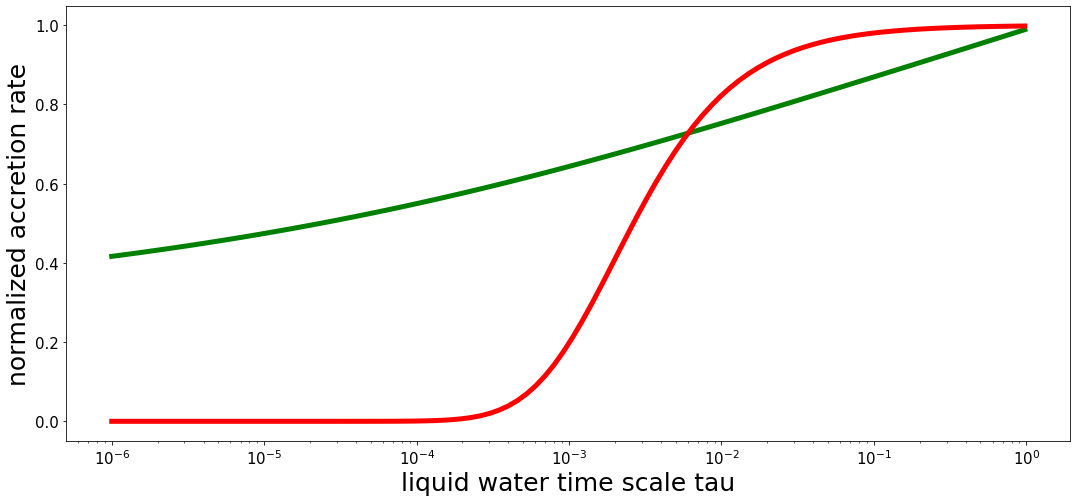

In [72]:

plt.plot(tau, acc2, 'g-', linewidth=5)
plt.plot(tau, phi, 'r-', linewidth=5)

plt.xlabel('liquid water time scale tau')
plt.ylabel('normalized accretion rate')

plt.yscale('linear')
plt.xscale('log')
plt.show()